The Geospatial Data Abstraction Library (GDAL) 

In [1]:
#import numpy as np, from matplotlib.pyplot import *
%pylab inline
from osgeo import gdal

Populating the interactive namespace from numpy and matplotlib


In [2]:
#1. Open the dataset - GDAL will iterate through all drivers and use the first that works.
ds = gdal.Open('data/M3_4030seg_L2_aristcrater.tif')
print(ds)
print(dir(ds))

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x103307540> >
['AddBand', 'BeginAsyncReader', 'BuildOverviews', 'CreateMaskBand', 'EndAsyncReader', 'FlushCache', 'GetDescription', 'GetDriver', 'GetFileList', 'GetGCPCount', 'GetGCPProjection', 'GetGCPs', 'GetGeoTransform', 'GetMetadata', 'GetMetadataItem', 'GetMetadata_Dict', 'GetMetadata_List', 'GetProjection', 'GetProjectionRef', 'GetRasterBand', 'GetSubDatasets', 'RasterCount', 'RasterXSize', 'RasterYSize', 'ReadAsArray', 'ReadRaster', 'ReadRaster1', 'SetDescription', 'SetGCPs', 'SetGeoTransform', 'SetMetadata', 'SetMetadataItem', 'SetProjection', 'WriteRaster', '__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattr__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_s',

In [4]:
#Determine how many bands the raster has
band_count = ds.RasterCount
band_count

83

In [5]:
#Visualize a band

<matplotlib.colorbar.Colorbar instance at 0x107f05f80>

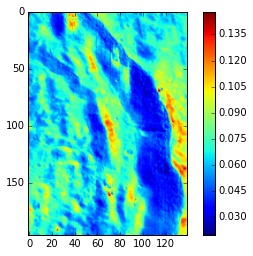

In [6]:
bnd = ds.GetRasterBand(1) #1 based
arr = bnd.ReadAsArray()
imshow(arr)
colorbar()

The defaul colorbar is the spectral one.  We can increase the figure size and get a grayscale colorbar easily.

<matplotlib.colorbar.Colorbar instance at 0x1087b2a70>

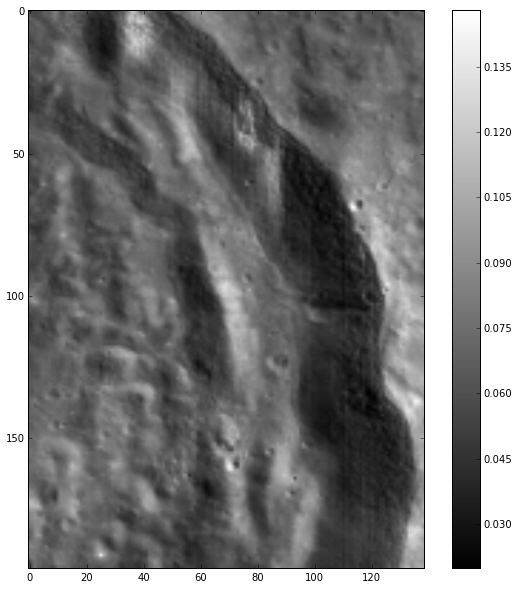

In [7]:
figsize(10,10)
arr = ds.GetRasterBand(1).ReadAsArray()  #Note the chained calls
imshow(arr, cmap='gray')
colorbar()

When the dataset is small enough to fit into memory, I find it easier to load the entire image and make a single GDAL call.

In [54]:
image = np.empty((ds.RasterYSize, ds.RasterXSize, ds.RasterCount), dtype=np.float32)
for i in range(ds.RasterCount):
    image[:, :, i] = ds.GetRasterBand(i + 1).ReadAsArray()

<matplotlib.colorbar.Colorbar instance at 0x108c73e18>

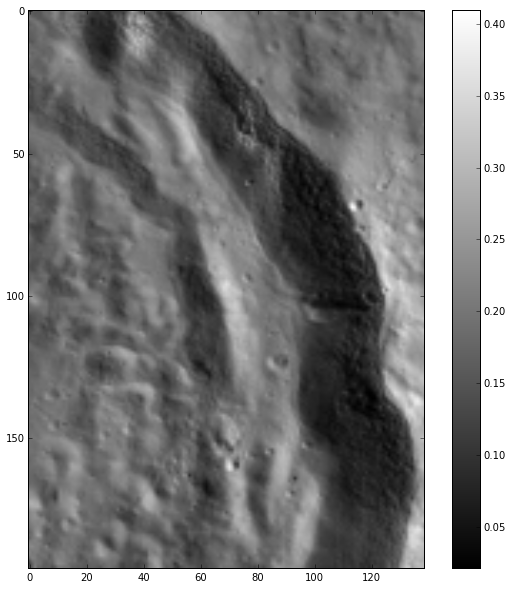

In [9]:
figsize(10,10)
imshow(image[:,:,64], cmap='gray')  #Band 64
colorbar()

If the dataset is large, it is possible to load a region of interest in much the same way. Note that the origin is the upper left hand corner.

In [10]:
image2 = np.empty((100, 100, ds.RasterCount), dtype=np.float32)  #A 100x100x83 memory buffer
for i in range(ds.RasterCount):
    image2[:, :, i] = ds.GetRasterBand(i + 1).ReadAsArray(0,0,100,100) #xoffset, yoffset, xcount, ycount

<matplotlib.colorbar.Colorbar instance at 0x109aff488>

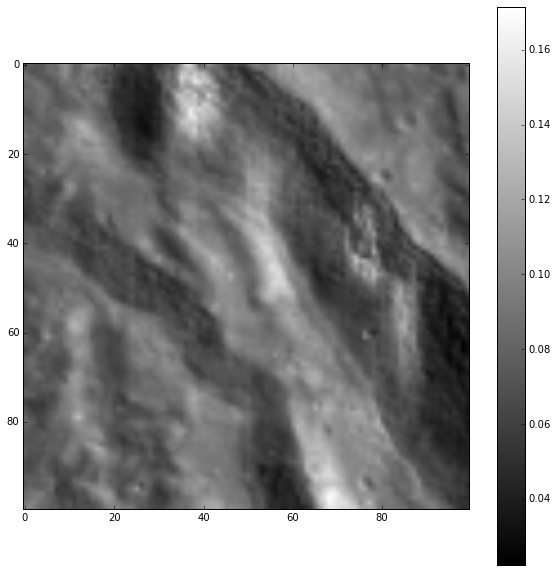

In [11]:
figsize(10,10)
imshow(image2[:,:,4], cmap='gray')
colorbar()

It is also possible to use fancy indexing to get a 3 color composite from arbitrary bands.

<matplotlib.colorbar.Colorbar instance at 0x109f97518>

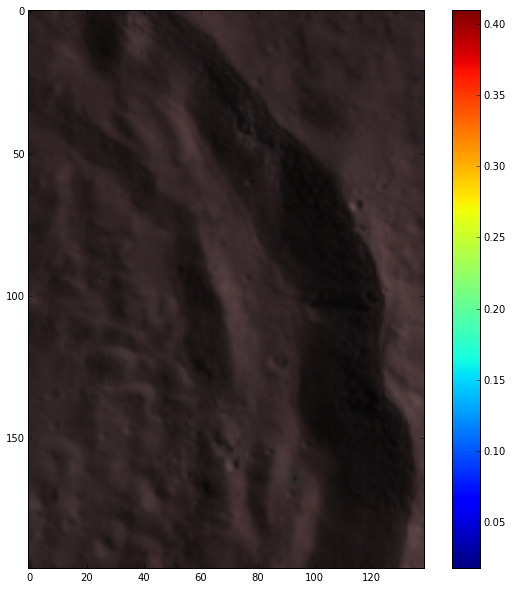

In [12]:
rgb = [64, 37, 40]  #Randomly selected
figsize(10,10)  #figsize 'carries' once it is defined, I am reusing it for cut and pasters.
img = imshow(image[:,:,rgb])
colorbar(mappable=img)

###Band number to wavelengths
The previous examples simply illustrated visualization of a GDAL extracted array, and the use of fancy indexing.  To be useful in an Exploratory Data Analysis (EDA) contenxt, we require more information.  Namely, what wavelengths have been captured and what is the mapping of wavelength to band number.

We will use a series of functions to make this process portable.

In [13]:
def get_band_numbers(image_wavelengths, *args):
    """
    Search the input image_wavelengths list for each wavelength contains in *args
    for the closest band index.
    
    Parameters
    ----------
    image_wavelengths : list
                        A list of wavelengths contained within the image
    
    *args : list
            A list of wavelengths to query to find the nearest band index.
    
    Returns
    -------
    bands : list
            A list of band indices
    """
    bands = []
    for i in args: #iterate over all the input, query wavelengths
        bands.append(min(range(len(image_wavelengths)), key=lambda j: abs(image_wavelengths[j] - i)))
    return bands

####Brief interlude - docstrings

Why on earth would we write such a verbose doc string in such as esoteric format?  This is a NumPyDoc compliant document that can be parsed by a huge number of tools.  One of these, Sphinx, is what is used by most Python packages to generate documentation.  The Python documentation we saw previsouly is all generated via these docs.

We also commonly embed unit tests into these docs.  These provide great test vehichles for devs. and great examples for end used.  Please write docs (and tests....before you write logic...)

Try the cell below to see how IPyhton parses the docstring.

In [14]:
get_band_numbers?

#### Back at it
Now that we have a function that can find the nearest band number, we need to be able to feed it with a list of wavelengths.  Luckily, GDAL gives us the option to get metadata from the input image.  We are also lucky that this dataset has the metadata embedded.  Some missions do not, and different files, or manual entry are required.

In [15]:
metadata = ds.GetMetadata()
print metadata

{'Band_53': 'Resize (Band 55:M3G20090205T074030_V01_RFL.IMG) (1778.479980)', 'Band_50': 'Resize (Band 52:M3G20090205T074030_V01_RFL.IMG) (1658.709961)', 'Band_51': 'Resize (Band 53:M3G20090205T074030_V01_RFL.IMG) (1698.630005)', 'Band_32': 'Resize (Band 34:M3G20090205T074030_V01_RFL.IMG) (1249.489990)', 'Band_75': 'Resize (Band 77:M3G20090205T074030_V01_RFL.IMG) (2656.810059)', 'Band_83': 'Resize (Band 85:M3G20090205T074030_V01_RFL.IMG) (2976.199951)', 'Band_33': 'Resize (Band 35:M3G20090205T074030_V01_RFL.IMG) (1269.449951)', 'Band_65': 'Resize (Band 67:M3G20090205T074030_V01_RFL.IMG) (2257.570068)', 'Band_64': 'Resize (Band 66:M3G20090205T074030_V01_RFL.IMG) (2217.639893)', 'Band_67': 'Resize (Band 69:M3G20090205T074030_V01_RFL.IMG) (2337.419922)', 'Band_66': 'Resize (Band 68:M3G20090205T074030_V01_RFL.IMG) (2297.489990)', 'Band_61': 'Resize (Band 63:M3G20090205T074030_V01_RFL.IMG) (2097.870117)', 'Band_56': 'Resize (Band 58:M3G20090205T074030_V01_RFL.IMG) (1898.250000)', 'Band_63': 

So we have a gnarly looking dictionary and we want to get a list of wavelengths.

In [16]:
import re

def metadata_to_band(metadata):    
    """
    Extract M3 wavelength information from metadata.
    
    Parameters
    ----------
    metadata : dict
               GDAL extracted metadata dictionary
    
    Returns
    --------
    wv2band : list
              A sorted list of wavelengths where index is the band number
    """
    
    wv2band = []
    for k, v in metadata.iteritems():
        wavelength = v.split(" ")[-1]
        wv2band.append(float(re.findall("\d+.\d+", wavelength)[0]))
    wv2band.sort(key=int)
    return wv2band

wv2band = metadata_to_band(metadata)
wv2band

[540.840027,
 580.76001,
 620.690002,
 660.609985,
 700.539978,
 730.47998,
 750.440002,
 770.400024,
 790.369995,
 810.330017,
 830.289978,
 850.25,
 870.210022,
 890.169983,
 910.140015,
 930.099976,
 950.059998,
 970.02002,
 989.97998,
 1009.950012,
 1029.910034,
 1049.869995,
 1069.829956,
 1089.790039,
 1109.76001,
 1129.719971,
 1149.680054,
 1169.640015,
 1189.599976,
 1209.569946,
 1229.530029,
 1249.48999,
 1269.449951,
 1289.410034,
 1309.380005,
 1329.339966,
 1349.300049,
 1369.26001,
 1389.219971,
 1409.189941,
 1429.150024,
 1449.109985,
 1469.069946,
 1489.030029,
 1508.98999,
 1528.959961,
 1548.920044,
 1578.859985,
 1618.790039,
 1658.709961,
 1698.630005,
 1738.560059,
 1778.47998,
 1818.400024,
 1858.329956,
 1898.25,
 1938.180054,
 1978.099976,
 2018.02002,
 2057.949951,
 2097.870117,
 2137.800049,
 2177.719971,
 2217.639893,
 2257.570068,
 2297.48999,
 2337.419922,
 2377.340088,
 2417.26001,
 2457.189941,
 2497.110107,
 2537.030029,
 2576.959961,
 2616.879883,
 26

Now we can visualize bands based on wavelength.  For example, we know that the standard IR Albedo is at the 1579 wavelength.

[47]


<matplotlib.colorbar.Colorbar instance at 0x10adbac20>

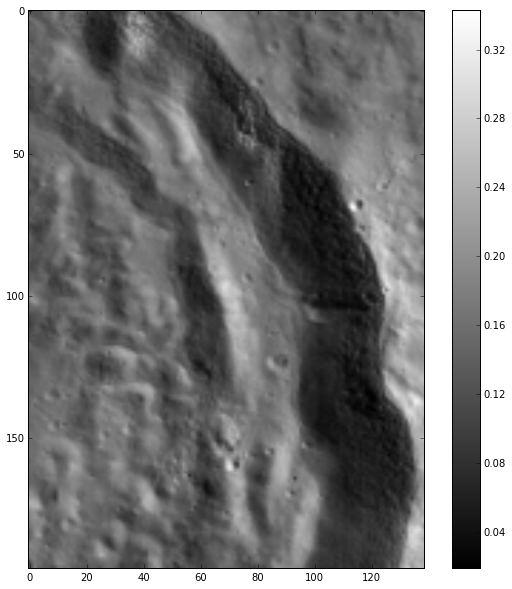

In [17]:
#Get the band(s)
bands = get_band_numbers(wv2band, 1579)
print(bands)

#Plot using fancy indexing
figsize(10,10)
img = imshow(image[:,:,bands[0] + 1],cmap='gray' )  #Remeber + 1 because bands are 1 based and the list is 0 based
colorbar(mappable=img)

From here, we can compute some simple ratios using wavelengths, as opposed to having to perform lookups.  For eample,

$mafic_{absoprtion} = \frac{949nm}{749nm}$

<matplotlib.colorbar.Colorbar instance at 0x10af193f8>

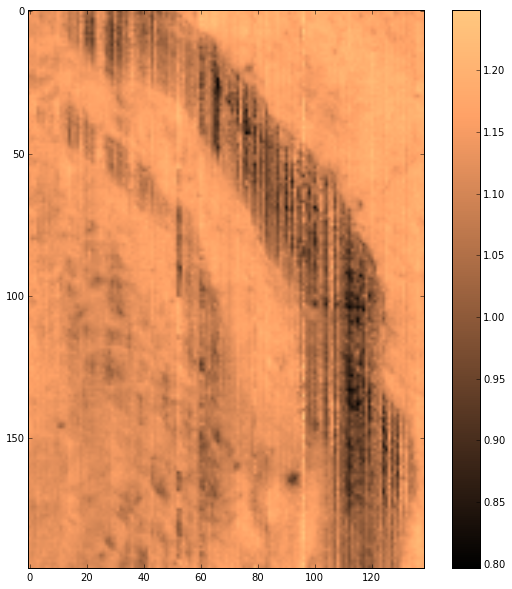

In [18]:
band949, band749 = get_band_numbers(wv2band, 949, 749)
R949 = image[:, :, band949 + 1]
R749 = image[:, :, band749 + 1]
mafic_abs = R949 / R749
imshow(mafic_abs, cmap='copper')
colorbar()

But, we are missing a step here...the data is being read and a ratio applied, but we need to perform a continuum correction.  Lets use the 'Mustard' correction with endpoints at 730nm, 1600nm, and 2500nm.

We do a quick line plot below to visualize the correction.  I'll look more at working with spectra in a bit.

In [75]:
band730, band1600, band2500 = get_band_numbers(wv2band, 730, 1600, 2500)
R730 = image[:,:,band730 + 1]
R1600 = image[:,:,band1600 + 1]
R2500 = image[:, :, band2500 + 1]

#get the exact wavelengths from the image metadata
wv1 = wv2band[band730]
wv2 = wv2band[band1600]
wv3 = wv2band[band2500]

m1 = (R1600 - R730) / (wv2 - wv1)
b1 = R1600 - (m1 * wv2)
m2 = (R2500 - R1600) / (wv3 - wv2)
b2 = R2500 - (m2 * wv3)

Now that we have a piece-wise linear continuum, lets plot the spectra at some pixel location.

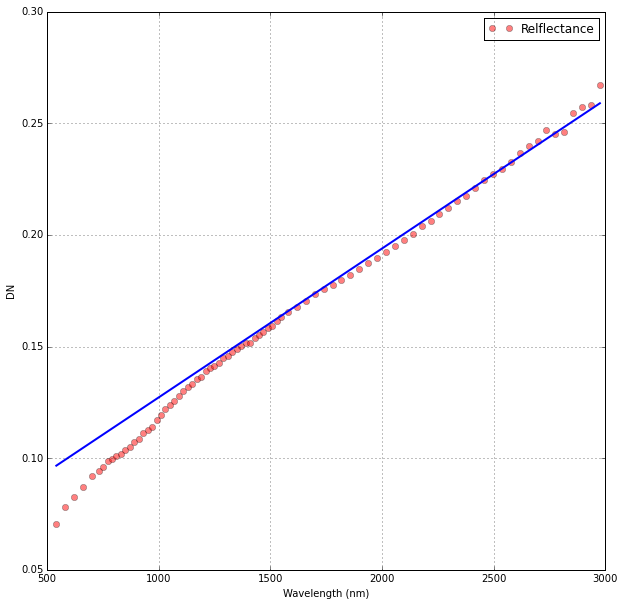

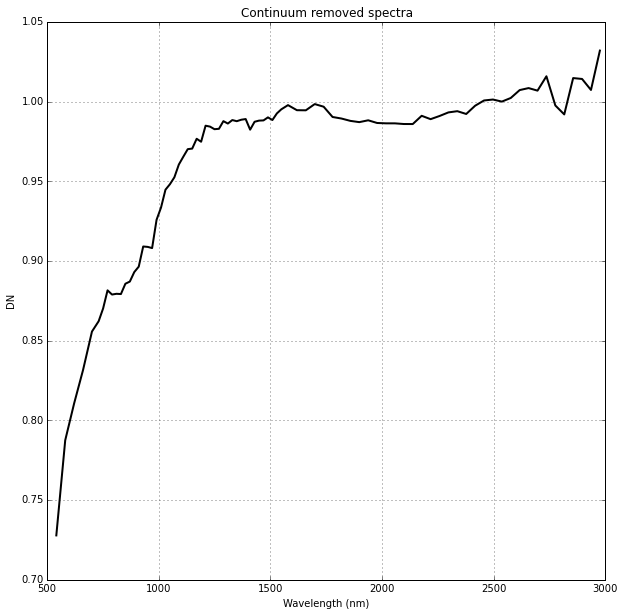

In [85]:
#Plot the raw spectra
x = np.array(wv2band)
y = image[35, 26, :]
plot(x, y, 'ro', label='Relflectance', alpha=0.5)


#Compute the 2 part linear fit and plot
lower = x[x <= band1600]
upper = x[x >= band1600]

plot(lower, m1[35, 26] * lower + b1[35, 26], 'b-', linewidth=2)
plot(upper, m2[32, 26] * upper + b2[35, 26], 'b-', linewidth=2)

xlabel('Wavelength (nm)')
ylabel('DN')
grid()
legend()
show()  #Force the plot to draw, we will draw another one in the same cell

#Concatenate the upper and lower continuum and remove.
continuum = np.concatenate((m1[35, 26] * lower + b1[35, 26],
                           m2[32, 26] * upper + b2[35, 26]))

plot(x, y / continuum, 'k-', linewidth=2)
grid()
title('Continuum removed spectra')
xlabel('Wavelength (nm)')
ylabel('DN')

Now we can apply the continuum correction to the entire image.  Since we are using the 794nm and 949nm bands, we only need the 'lower' half of the Mustard continuum.

<matplotlib.colorbar.Colorbar instance at 0x10c88f3f8>

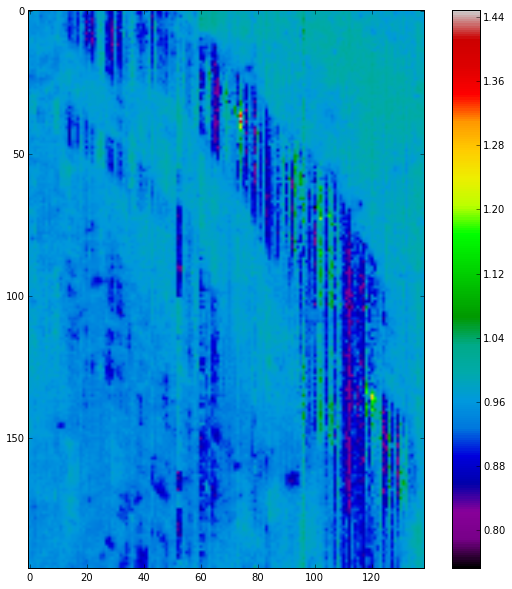

In [23]:
def compute_continuum(wv, shape):
    """
    Helper function for broadcasting the wavelength 
    array to the correct shape
    
    Parameters
    -----------
    wv : float
         The wavelength
         
    shape : tuple
            (y, x) shape of the returned array
            
    Returns
    -------
    wvarray : array
              y, x shape array filled with wv
    """
    wvarray = np.empty(shape)
    wvarray[:] = wv
    return wvarray


band949, band749 = get_band_numbers(wv2band, 949, 749)
R949 = image[:, :, band949 + 1]
R749 = image[:, :, band749 + 1]
x = compute_continuum(wv2band[band949], R949.shape)
R949 /= (m1 * x + b1)# In place division
x = compute_continuum(wv2band[band749], R749.shape)
R749 /= (m1 * x + b1)

mafic_abs = R949 / R749
imshow(mafic_abs, cmap='spectral')
colorbar()

##Hands on
This is a short hands on exercise where you will implement a derived product algorithm.  Here are two (one simple and one a little more complex).

1. IR Albedo is simply relfenctance at 1579nm.  What does that look like?
2. Alternatively, something simple, but interesting - a ratio maybe?